In [ ]:
""" Nama Kelompok:
        C14210194    Christopher Giovanni
        C14200082    Jason Setiono
    Judul Proyek:
        Image Captioning with CNN and Attention
        
        Sumber Inspirasi:
        Daoust, M. (2018). "Image captioning with visual attention".
        https://www.tensorflow.org/text/tutorials/image_captioning
"""

In [1]:
""" Import Libraries """

import tensorflow as tf
from tensorflow.keras import layers
# Source: https://www.tensorflow.org/addons
import tensorflow_addons as tfa
# Source: https://huggingface.co/google-bert/bert-base-uncased
from transformers import BertTokenizer
import numpy as np
# Source: https://einops.rocks/
import einops
os, random

# To prevent OOM (Out of Memory)
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
""" Declare Parameters & Models """

IMAGE_SIZE = (256, 256)
MAX_ROTATION_ANGLE = 10
MAX_SEQ_LENGTH = 40    # max tokens length to be included from Flickr8k
BATCH_SIZE = 16
VOCAB_SIZE = 30522    # bert-base-uncased vocab size

# Source: https://keras.io/api/applications/resnet/#resnet50-function
cnn_preprocessing = tf.keras.applications.resnet50.preprocess_input
cnn_model = tf.keras.applications.ResNet50(include_top=False)
# Source: https://huggingface.co/google-bert/bert-base-uncased
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Kita declare variabel-variabel penting. Max rotation angle ada untuk merotate image 
secara random pada proses training namun tidak terlalu banyak hingga merusak label. 
Kami berpikir bahwa dengan begitu kami dapat menambahkan variasi pada image yang ditrain ke model. 

Untuk model CNN, kami mengambil model dari Library Keras.Applicattions
yang telah menyediakan CNN ResNet50 beserta dengan fungsi preprocessingnya yang 
telah ditrain dengan ImageNet. Kami me-load model tanpa classification head-nya. 

Untuk tokenizer, kami me-load tokenizer yang digunakan model BERT dari Library Transformers. 
Kami melakukannya karena tokenizer BERT memiliki jumlah vocabulary yang luas, dan kemampuannya untuk menyambung/memisah 1 kata menjadi beberapa token.

In [3]:
""" Import Flickr8K Dataset """

# Source: https://kaggle.com/datasets/adityajn105/flickr8k
def load_flickr8k():
    annotations = open('../../Datasets/Flickr8K/Flickr8k_text/Flickr8k.token.txt', 'r').read()
    
    # load image path and caption
    img_paths, captions = [], []
    for line in annotations.split('\n')[:-1]:
        img_path, caption = line.split('\t')
        img_path = img_path.split('#')[0]
        img_path = os.path.join('../../Datasets/Flickr8K/Flickr8k_image/', img_path.strip())
        
        if os.path.exists(img_path) and len(caption.split(' ')) <= MAX_SEQ_LENGTH:
            img_paths.append(img_path)
            captions.append(caption)

    return img_paths, captions


img_paths, captions = load_flickr8k()
for path, caption in zip(img_paths[:10], captions[:10]):
    print(path, caption[:70])

../../Datasets/Flickr8K/Flickr8k_image/1000268201_693b08cb0e.jpg A child in a pink dress is climbing up a set of stairs in an entry way
../../Datasets/Flickr8K/Flickr8k_image/1000268201_693b08cb0e.jpg A girl going into a wooden building .
../../Datasets/Flickr8K/Flickr8k_image/1000268201_693b08cb0e.jpg A little girl climbing into a wooden playhouse .
../../Datasets/Flickr8K/Flickr8k_image/1000268201_693b08cb0e.jpg A little girl climbing the stairs to her playhouse .
../../Datasets/Flickr8K/Flickr8k_image/1000268201_693b08cb0e.jpg A little girl in a pink dress going into a wooden cabin .
../../Datasets/Flickr8K/Flickr8k_image/1001773457_577c3a7d70.jpg A black dog and a spotted dog are fighting
../../Datasets/Flickr8K/Flickr8k_image/1001773457_577c3a7d70.jpg A black dog and a tri-colored dog playing with each other on the road 
../../Datasets/Flickr8K/Flickr8k_image/1001773457_577c3a7d70.jpg A black dog and a white dog with brown spots are staring at each other
../../Datasets/Flickr8K/Fl

Kami menggunakan dataset Flickr8k yang berisi gambar yang disertai caption mereka.
Setiap 1 gambar disertai 5 caption yang berbeda.
Dari annotation yang mereka berikan, kami meng-ekstrak path untuk gambar beserta captionnya.

In [4]:
""" Preprocess Dataset """

def load_image(img_path, token):
    img = tf.io.decode_jpeg(tf.io.read_file(img_path))
    img = tf.image.resize(img, IMAGE_SIZE)
    
    return img, token

def augment_image(img, token):
    # Random Rotate
    rotation_angle = MAX_ROTATION_ANGLE * (np.pi / 180.0)
    rotation = tf.random.uniform([], -rotation_angle, rotation_angle, dtype=tf.float32)
    img = tfa.image.rotate(img, rotation)
    
    # Random flip, brightness, contrast
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_brightness(img, 0.2)
    img = tf.image.random_contrast(img, 0.8, 1.0)
    
    return img, token

def process_input(image, token):
    # Split token to token_in, token_out
    token_in = token['input_ids'][..., :-1]
    token_out = token['input_ids'][..., 1:]
    # Get length of tokens without 0 padding
    token_length = tf.reduce_sum(tf.cast(tf.not_equal(token_in, 0), tf.int32), axis=-1)
    return (image, token_in, token_length), token_out


# tokenize sentences, standardization included
tokens = bert_tokenizer.batch_encode_plus(
    captions,
    max_length=MAX_SEQ_LENGTH + 1,
    padding=True,
    truncation=True
)

In [5]:
# Create tf Dataset pipeline from img_paths and tokenized captions
dataset = tf.data.Dataset.from_tensor_slices((img_paths, tokens))
dataset = dataset.map(load_image, tf.data.AUTOTUNE)

# Split train, valid dataset
n = int(dataset.cardinality().numpy() * 0.80)
train_ds = dataset.take(n)\
           .map(augment_image, tf.data.AUTOTUNE)\
           .map(process_input, tf.data.AUTOTUNE)\
           .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
valid_ds = dataset.skip(n)\
           .map(process_input, tf.data.AUTOTUNE)\
           .batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

for (image, token_in, token_length), token_out in train_ds.take(1):
    print('Image shape:', image.shape)
    print('Token in shape:', token_in.shape)
    print('Token length shape:', token_length.shape)
    print('Token out shape:', token_out.shape)

Image shape: (16, 256, 256, 3)
Token in shape: (16, 40)
Token length shape: (16,)
Token out shape: (16, 40)


Dari image_path dan caption, kami membuat tf.Dataset pipeline dimana untuk mengambil data dari
tf Dataset tersebut, image_path akan diload dan diaumentasi, 
yang berupa random rotate, flip, brightness, contrast. 
Setelah itu, kami proses agar input model (image, token_in, token_length) dan outputnya token_out.

Kami pecah dataset menjadi dua, yaitu train_ds sebanyak 80% dari dataset dan 
valid_ds sebanyak 20% dari dataset.

In [6]:
""" Positional Embedding Layer """

class ReversePositionalEmbedding(layers.Layer):
    """ Berbeda dengan normal positional embedding dimana sequence kalimat bersifat urut,
        fungsi ini membalikan urutan sequence dari position encoding. 
        Positional Embedding:
            This   is     a      sample of     text  .
            0      1      2      3      4      5     6     0     0     0
        Reverse Positional Embedding:
            This   is     a      sample of     text  .
            6      5      4      3      2      1     0     0     0     0
            
        Dengan cara ini, model dapat mengetahui informasi tentang sisa token yang dapat
        di-generate di setiap decoding step. 
        
            Sumber Inspirasi:
            Miculicich, L et al. (2023). "Summarization with Precise Length Control". 
            https://arxiv.org/abs/2305.05171 
    """
    
    def __init__(self, vocab_size, max_seq_length, embedding_dim, dropout_rate=0.0):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.text_embedding = layers.Embedding(vocab_size, embedding_dim)
        self.pos_embedding = layers.Embedding(max_seq_length, embedding_dim)
        self.dropout = layers.Dropout(dropout_rate)
        
    def get_reverse_sequence(self, seq_length):
        batch_size = tf.shape(seq_length)[0]
        reverse_sequence = tf.reverse_sequence(
            tf.reshape(
                tf.tile(tf.range(self.max_seq_length), [batch_size]), 
                [batch_size, self.max_seq_length]
            ),
            seq_length, seq_axis=1, batch_axis=0
        )
        # Random noise from -1 to 1 in Int32
        noise = tf.random.uniform(
            shape=[tf.shape(seq_length)[0], self.max_seq_length], 
            minval=-1, maxval=1, dtype=tf.int32
        )
        
        return reverse_sequence + noise
    
    def call(self, x, seq_length):
        length = tf.shape(x)[-1]
        reverse_sequence = self.get_reverse_sequence(seq_length)
        x = self.text_embedding(x)
        x = x + self.pos_embedding(reverse_sequence)[:, :length]
        return self.dropout(x)


Kami mengganti Positional Embedding biasa dengan Reverse Positional Embedding dimana 
sequence position dibalik, agar model dapat dilatih untuk mengenerate panjang kata yang berbeda-beda.

Dikarenakan dataset kami memiliki 1 gambar dan 5 caption yang berbeda-beda, model dapat 
bingung akan mana caption yang sesungguhya. Namun dengan Reverse Positional Embedding, 
input token_length dari dataset adalah satu-satunya pembeda yang bisa dipelajari model, untuk 
membedakan label caption yang satu dengan yang lainnya. Hal ini membuat model dapat belajar untuk
men-generate kalimat dengan panjang yang berbeda-beda.

Kami menambahkan noise pada reverse sequence, agar model tidak terlalu terpaku pada sequence.
Tanpa noise, model akan belajar untuk selalu berhenti men-generate kalimat saat sequence telah
mencapai 0, meskipun caption yang di-generate belum selesai.
Dengan menambahkan noise juga membuat model lebih fleksibel dalam menentukan kapan ia akan berhenti untuk men-generate kalimat yang terbaik.

In [7]:
""" Attention and FeedForward Layer """

class BaseAttention(layers.Layer):
    def __init__(self, num_heads, key_dim, dropout_rate=0.0):
        super().__init__()
        self.mha = layers.MultiHeadAttention(num_heads, key_dim, dropout=dropout_rate)
        self.norm = layers.LayerNormalization()
    
class CausalSelfAttention(BaseAttention):
    def call(self, x):
        return self.norm(x + self.mha(x, x, x, use_causal_mask=True))
    
class CrossAttention(BaseAttention):
    def call(self, x, context):
        output, attn_score = self.mha(x, context, return_attention_scores=True)
        self.attn_score = attn_score    # Cache attn score for plotting
        return self.norm(x + output)
    

class FeedForward(layers.Layer):
    def __init__(self, d_model, dff, dropout_rate=0.0):
        super().__init__()
        self.feedforward = tf.keras.Sequential([
            layers.Dense(dff, activation='relu'),
            layers.Dense(d_model),
            layers.Dropout(dropout_rate)
        ])
        self.norm = layers.LayerNormalization()
        
    def call(self, x):
        return self.norm(x + self.feedforward(x))
    

In [8]:
""" Decoder Layer """

class Decoder(layers.Layer):
    def __init__(self, d_model, dff, num_heads, dropout_rate=0.1):
        super().__init__()
        self.self_attention = CausalSelfAttention(num_heads, d_model, dropout_rate)
        self.cross_attention = CrossAttention(num_heads, d_model, dropout_rate)
        self.feedforward = FeedForward(d_model, dff, dropout_rate)
    
    def call(self, enc_out, dec_out):
        dec_out = self.self_attention(dec_out)
        x = self.cross_attention(dec_out, enc_out)
        x = self.feedforward(x)
        return x
    

In [9]:
class ImageCaptioner(tf.keras.Model):
    def __init__(self, cnn_preprocessing, cnn_model, text_tokenizer, vocab_size, max_seq_length,
                 d_model, dff, num_heads, num_layers, dropout_rate=0.0, **kwargs):
        super(ImageCaptioner, self).__init__(**kwargs)
        
        # CNN models
        self.cnn_preprocessing = cnn_preprocessing
        self.cnn_model = cnn_model
        self.cnn_model.trainable = False
        
        # Text tokenizer
        self.max_seq_length = max_seq_length
        self.text_tokenizer = text_tokenizer
        
        # Pos encoding, decoder, output layer
        self.positional_embedding = ReversePositionalEmbedding(
            vocab_size, max_seq_length, d_model, dropout_rate
        )
        self.decoders = [
            Decoder(d_model, dff, num_heads, dropout_rate) for _ in range(num_layers)
        ]
        self.dense = layers.Dense(vocab_size, activation='softmax')
        
    def call(self, inputs):
        image, token_in, seq_length = inputs
        
        image = self.cnn_preprocessing(image)
        feature_map = self.cnn_model(image)
        # Flatten height and width dims to one dimension to match with token_in shape
        feature_map = einops.rearrange(feature_map, 'b h w c -> b (h w) c')
        
        # Passed with desired seq_length
        token_in = self.positional_embedding(token_in, seq_length)
        for decoder in self.decoders:
            token_in = decoder(feature_map, token_in)
            
        output = self.dense(token_in)
        return output
        
    def nucleus_sampling(self, logits, top_p, temperature):
        """ Nucleus Sampling memilih set terkercil dari vocabulary dimana jumlah
            probabilitas mereka > p. Intinya, ketika model sangat yakin pada sedikit token,
            set dari calon token akan mengecil, dan sebalikya.
            Ini memungkinkan model untuk memilih token dari set token yang paling memungkinkan
            dan tidak menghiraukan kata yang tidak memungkinkan. 
            
                Sumber Inspirasi:
                Holtzman, A. et al. (2019). "The Curious Case of Neural Text Degeneration".
                https://arxiv.org/abs/1904.09751
        """
        
        # Create mask to select only set of words where sum > p
        sorted_indices = tf.argsort(logits, direction='DESCENDING')
        sorted_logits = tf.gather(logits, sorted_indices)
        cumulative_probs = tf.math.cumsum(tf.nn.softmax(sorted_logits))
        probs_mask = (cumulative_probs < top_p).numpy()
        probs_mask[0] = True
        probs_mask = tf.cast(probs_mask, tf.float32)
        probs_mask = tf.gather(probs_mask, tf.argsort(sorted_indices))
        
        # Temperature sampling with masked word pool
        masked_logits = logits * probs_mask
        masked_logits = tf.math.log(masked_logits) / temperature
        next_token = tf.random.categorical([masked_logits], num_samples=1)
        
        return tf.squeeze(next_token)
    
    def generate_caption(self, image, seq_length, top_p=1.0, temperature=1.0, return_tokens=False):
        tokens = self.text_tokenizer.encode(['[CLS]'])[1:-1]    # Start token in BERT vocab
        tokens = tf.convert_to_tensor(tokens)
        # Decoder Steps (generate tokens sequentially)
        for _ in range(self.max_seq_length):
            prob = self.call([image[tf.newaxis, ...], tokens[tf.newaxis, ...], [seq_length]])
            prob = tf.squeeze(prob[:, -1, :])    # Get probability in last sequence
            
            next_token = self.nucleus_sampling(prob, top_p, temperature)
            if next_token == self.text_tokenizer.encode(['[SEP]'])[1:-1]:    # End token in BERT vocab
                break
                
            tokens = tf.concat((tokens, [next_token]), axis=0)
            
        # Decode and join tokens to text
        caption = self.text_tokenizer.decode(tokens[1:])
        tokens = [self.text_tokenizer.decode(token) for token in tokens[1:]]
        return (caption, tokens) if return_tokens else caption
    

Kami membuat model dengan struktur hampir sama seperti Transformer pada umumnya.
Kami mengganti Encoder menjadi ResNet50 untuk memproses image.
Kami lakukan Reverse Positional Embedding pada token_in dengan token_length.

Sebelum kita pass ke Decoder, kita harus menyamakan dimensi token_in dan feature_map
dengan einops.rearrange().
Token_in shape dari Reverse Pos Embedding: Batch_size, seq_length, embed_dim
Feature_map shape dari ResNet50: Batch_size, height, width, channel

Kami juga menggunakan Nucleus Sampling sebagai strategi untuk men-sample token dari output
probabilitas model.

In [10]:
tf.keras.backend.clear_session()    # To avoid clutter from old layers, when re-running cell
captioner = ImageCaptioner(
    cnn_preprocessing=cnn_preprocessing,
    cnn_model=cnn_model, 
    text_tokenizer=bert_tokenizer,
    vocab_size=VOCAB_SIZE,
    max_seq_length=MAX_SEQ_LENGTH,
    d_model=512,
    dff=1024,
    num_heads=5,
    dropout_rate=0.5,
    num_layers=4,    # num of decoder layers
    name="ImageCaptioner"
)
# .expect_partial() to prevent loading error warnings
captioner.load_weights('model_weights/resnet50 + 4 decoder(512 units, 5 attn heads)/').expect_partial()

# Build model, print model summary
for inputs, output in train_ds.take(1):
    captioner(inputs)
captioner.summary()

Model: "ImageCaptioner"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, None, None, 2048)  23587712  
                                                                 
 reverse_positional_embeddin  multiple                 15647744  
 g (ReversePositionalEmbeddi                                     
 ng)                                                             
                                                                 
 decoder (Decoder)           multiple                  19419648  
                                                                 
 decoder_1 (Decoder)         multiple                  19419648  
                                                                 
 decoder_2 (Decoder)         multiple                  19419648  
                                                                 
 decoder_3 (Decoder)         multiple               

Kami menggunakan dropout rate yang besar, karena model sangat mudah untuk overfit dengan 
dropout yang lebih kecil.

In [13]:
def masked_loss(y_true, y_pred):
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False, reduction='none')
    loss = loss_fn(y_true, y_pred)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(loss * mask) / tf.reduce_sum(mask)

def accuracy(y_true, y_pred):
    y_pred = tf.argmax(y_pred, axis=-1)
    y_pred = tf.cast(y_pred, y_true.dtype)
    match = tf.cast(y_true == y_pred, tf.float32)
    mask = tf.cast(y_true != 0, tf.float32)
    
    return tf.reduce_sum(match * mask) / tf.reduce_sum(mask)
    

captioner.compile(
    optimizer=tf.keras.optimizers.Adam(2e-6),
    loss=masked_loss,
    metrics=[accuracy]
)
# captioner.fit(train_ds, validation_data=valid_ds, epochs=2)
# _ = captioner.evaluate(valid_ds)

Epoch 1/2
2023/2023 [==============================] - 371s 180ms/step - loss: 1.1477 - accuracy: 0.6745 - val_loss: 2.1130 - val_accuracy: 0.5598
Epoch 2/2
2023/2023 [==============================] - 371s 183ms/step - loss: 1.1331 - accuracy: 0.6769 - val_loss: 2.1172 - val_accuracy: 0.5596


Kami mentrain model kira-kira sebanyak 20 epochs. Kami memulai dari learning-rate 1e-3 dan menurunkannya saat model telah stagnan, hingga 2e-6. Akurasi akhir yang didapat model adalah 67% pada train_ds dan 55% pada valid_ds.

Kami berpikir bahwa akurasi yang kecil dapat disebabkan model dilatih menggunakan 
versi caption yang berbeda-beda untuk satu gambar dari dataset, 
dan kesulitan memilih jalan tengah yang dapat memuaskan semua versi caption.

In [16]:
# captioner.save_weights('model_weights/resnet50 + 4 decoder(512 units, 5 attn heads)/')

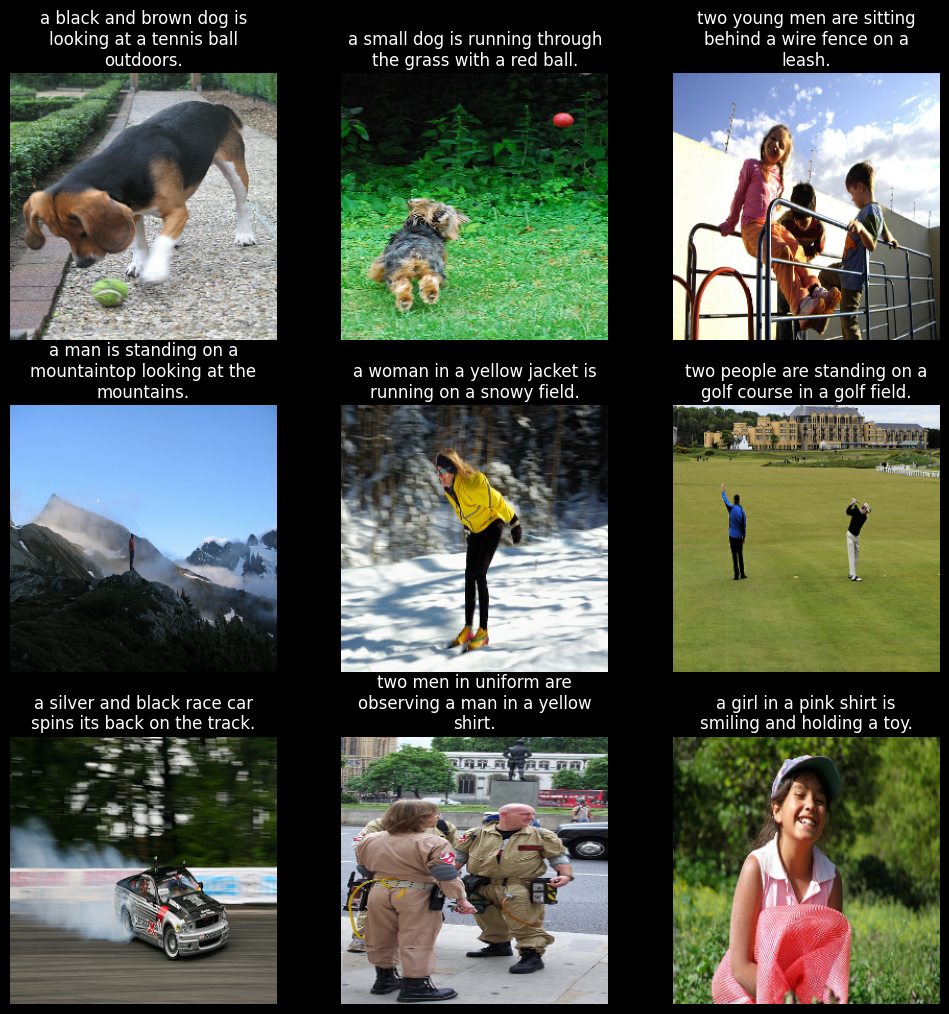

In [33]:
""" Model Testing """

import matplotlib.pyplot as plt
from textwrap import wrap

# Generate caption for sampled images from validation dataset
for (image, token_in, token_length), token_out in valid_ds.unbatch().shuffle(5000).batch(9).take(1):
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(image):
        # Edit seq_length parameter to produce generated_caption with desired lengths
        # Small top_p to generate only tokens that the model is certain, vice versa
        # Small temperature for more consistent sampling, vice versa
        caption = captioner.generate_caption(image, seq_length=15, top_p=.05, temperature=.1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype('int32'))
        plt.title('\n'.join(wrap(caption, 30)), fontsize=12)
        plt.axis('off')
        
    plt.tight_layout(pad=0.2, h_pad=.1, w_pad=.1)
    plt.show()

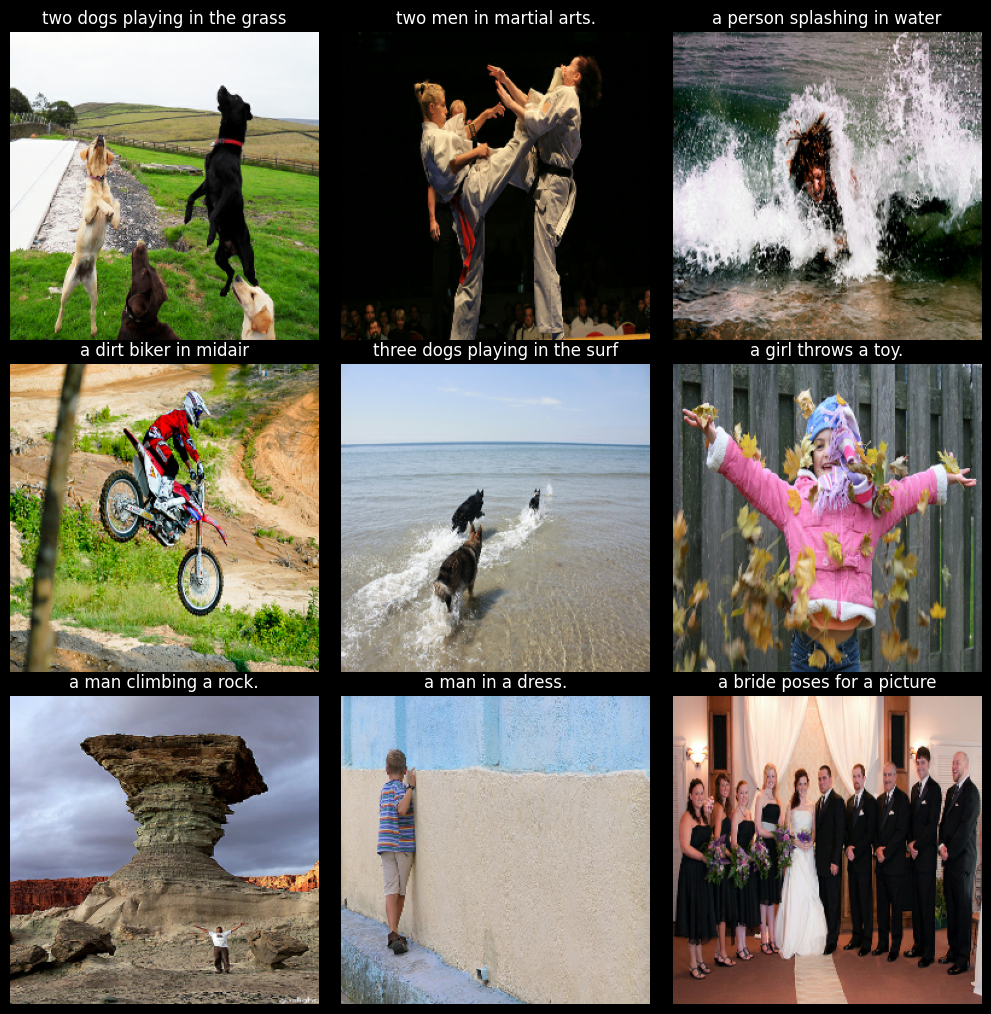

In [16]:
for (image, token_in, token_length), token_out in valid_ds.unbatch().shuffle(5000).batch(9).take(1):
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(image):
        caption = captioner.generate_caption(image, seq_length=8, top_p=.05, temperature=.1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype('int32'))
        plt.title('\n'.join(wrap(caption, 30)), fontsize=12)
        plt.axis('off')
        
    plt.tight_layout(pad=0.2, h_pad=.1, w_pad=.1)
    plt.show()

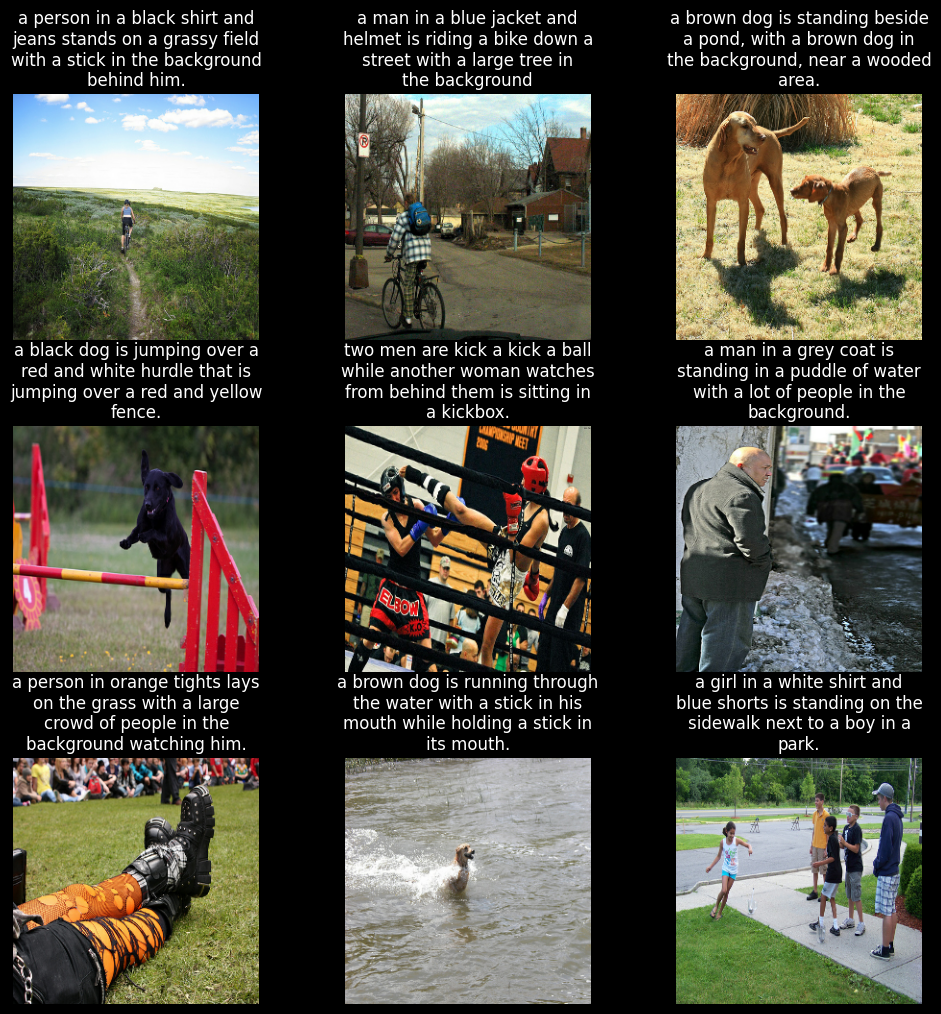

In [27]:
for (image, token_in, token_length), token_out in valid_ds.unbatch().shuffle(5000).batch(9).take(1):
    plt.style.use('dark_background')
    plt.figure(figsize=(10, 10))
    for i, image in enumerate(image):
        caption = captioner.generate_caption(image, seq_length=24, top_p=.05, temperature=.1)
        
        plt.subplot(3, 3, i + 1)
        plt.imshow(image.numpy().astype('int32'))
        plt.title('\n'.join(wrap(caption, 30)), fontsize=12)
        plt.axis('off')
        
    plt.tight_layout(pad=0.2, h_pad=.1, w_pad=.1)
    plt.show()

Saat men-testing model, kami mengambil sample gambar-gambar dari valid_ds dan mencoba men-generate
caption menggunakan model, dan mem-plotnya. Kita dapat memberikan parameter seq_length pada model untuk
men-generate caption dengan panjang yang diinginkan. Kita mencoba men-generate caption dengan panjang
token 15, 8, dan 24.

Pada kasus kalimat yang panjang, model seringkali meng-halusinasikan detail yang tidak ada pada gambar.
Hal ini kemungkinan karena model tidak dapat lagi melihat detail yang dapat ditambahkan ke kalimat dari
gambar yang diberikan, dan akan condong kepada sampel kata yang sering keluar dari dataset 
dengan caption yang panjang. Hal ini kemungkinan dapat diobati dengan menambahkan sebuah regression head pada model untuk memprediksi panjang kalimat yang optimal untuk sebuah gambar, jika tidak diberikan input panjang token yang diinginkan.

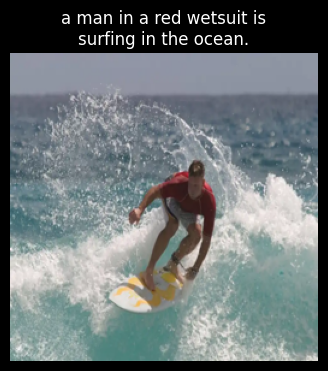

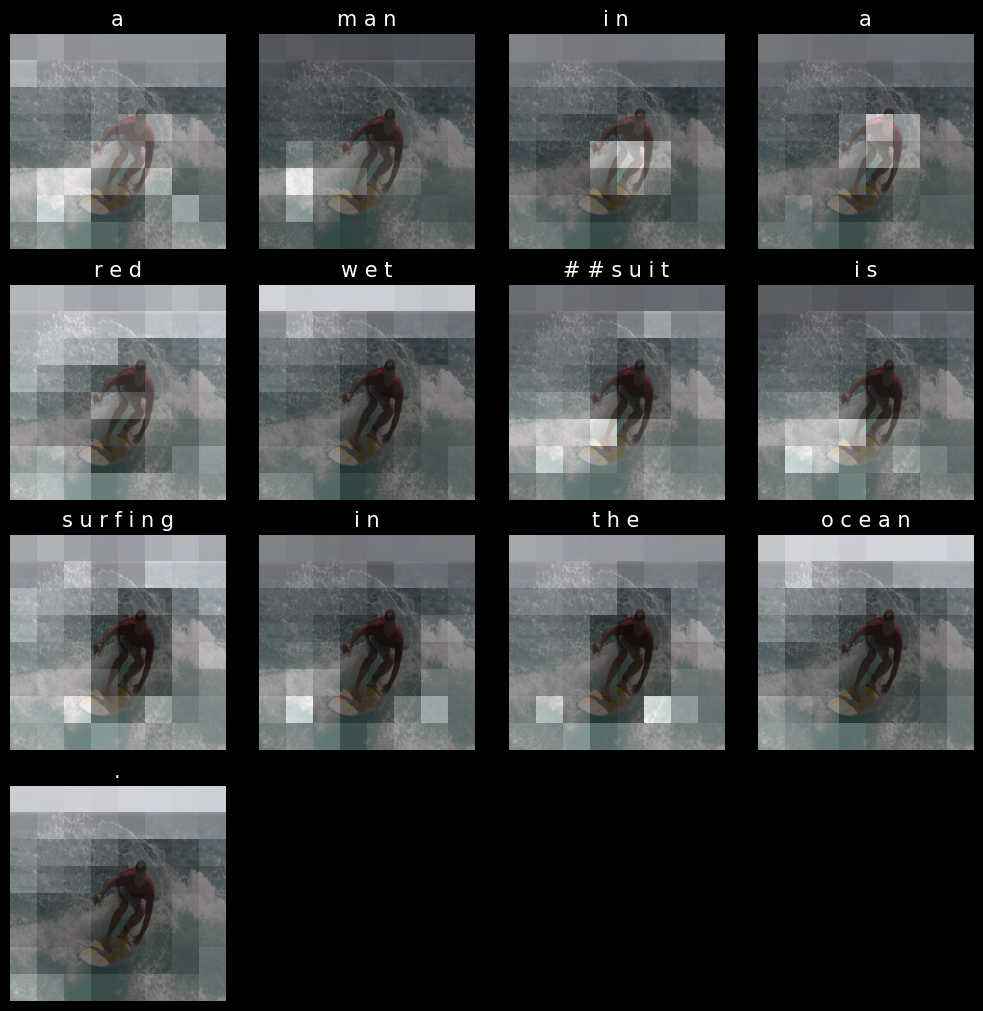

In [23]:
from PIL import Image, UnidentifiedImageError
import requests, subprocess, re
from io import BytesIO

def download_url(url, size=IMAGE_SIZE):
    try:
        headers = {'User-Agent': 'My User Agent 1.0'}
        image = Image.open(BytesIO(requests.get(url, headers=headers, stream=True).content))
        image = image.resize(size)
    except UnidentifiedImageError:
        raise
    return np.array(image).astype('uint8')
    
def get_attn_scores():
    attn_scores = [layer.cross_attention.attn_score for layer in captioner.decoders]
    attn_scores = tf.concat(attn_scores, axis=0)[-1:, :, 1:, :]
    attn_scores = einops.reduce(
        attn_scores,
        'batch heads sequence (height width) -> sequence height width',
        height=IMAGE_SIZE[0] // 32, width=IMAGE_SIZE[1] // 32,
        reduction='mean'
    )
    return attn_scores


# Sample image urls
image_urls = ['https://www.tensorflow.org/images/surf.jpg',
              'https://d1jyxxz9imt9yb.cloudfront.net/medialib/626/image/p1300x1300/2_Elephants-in-bush_reduced.webp',
              'https://assets-global.website-files.com/5ca5fe687e34be0992df1fbe/615ec25b20ec6f7f2a2f3a3f_KALENJthnmnauil19%20-%20002%20---%20Expires%20on%2002-01-2023-min-p-1080.jpeg',
              'https://upload.wikimedia.org/wikipedia/commons/d/d3/July_night_sky_%2835972569256%29.jpg',
              'https://www.earth.com/_next/image/?url=https%3A%2F%2Fcff2.earth.com%2Fuploads%2F2018%2F07%2F25115124%2FKids-now-spend-twice-as-much-time-playing-indoors-than-outdoors-850x500.jpg&w=2048&q=75',
              'https://149474751.v2.pressablecdn.com/wp-content/themes/elevation_theme/assets/images/img-b.jpg'
             ]
image = download_url(image_urls[0])    # Pick one of the urls above or insert your own url here
caption, tokens = captioner.generate_caption(image, seq_length=15, top_p=.1, temperature=.1, 
                                             return_tokens=True)
attn_scores = get_attn_scores()    # Get last decoder layer's attention scrore from their last run

# Plot image with their caption
plt.style.use('dark_background')
plt.figure(figsize=(4, 4))
plt.imshow(image)
plt.title('\n'.join(wrap(caption, 30)), fontsize=12)
plt.axis('off')
plt.show()

# Plot attention scores of image patches with their respective tokens
plt.style.use('dark_background')
fig = plt.figure(figsize=(10, 10 * 2.5))
for i, score in enumerate(attn_scores):
    ax = fig.add_subplot(10, 4, i + 1)
    ax = plt.gca()
    img = ax.imshow(image)
    ax.imshow(score, cmap='gray', alpha=0.6, extent=img.get_extent(),
              clim=[0.0, np.max(score)])
    plt.title(tokens[i], fontsize=15)
    plt.axis('off')
    
plt.tight_layout(pad=0.2, h_pad=.8)
plt.show()

In [ ]:
Kami mencoba memberikan image yang bersumber dari internet dan mem-plot attention yang dihasilkan pada
cross attention pada layer decode terakhir pada model, saat men-generate token tertentu. 
Kami tidak dapat melihat korelasi pada token yang sedang di-generate pada waktu itu
dengan wilayah gambar yang sedang diperhatikan attention.

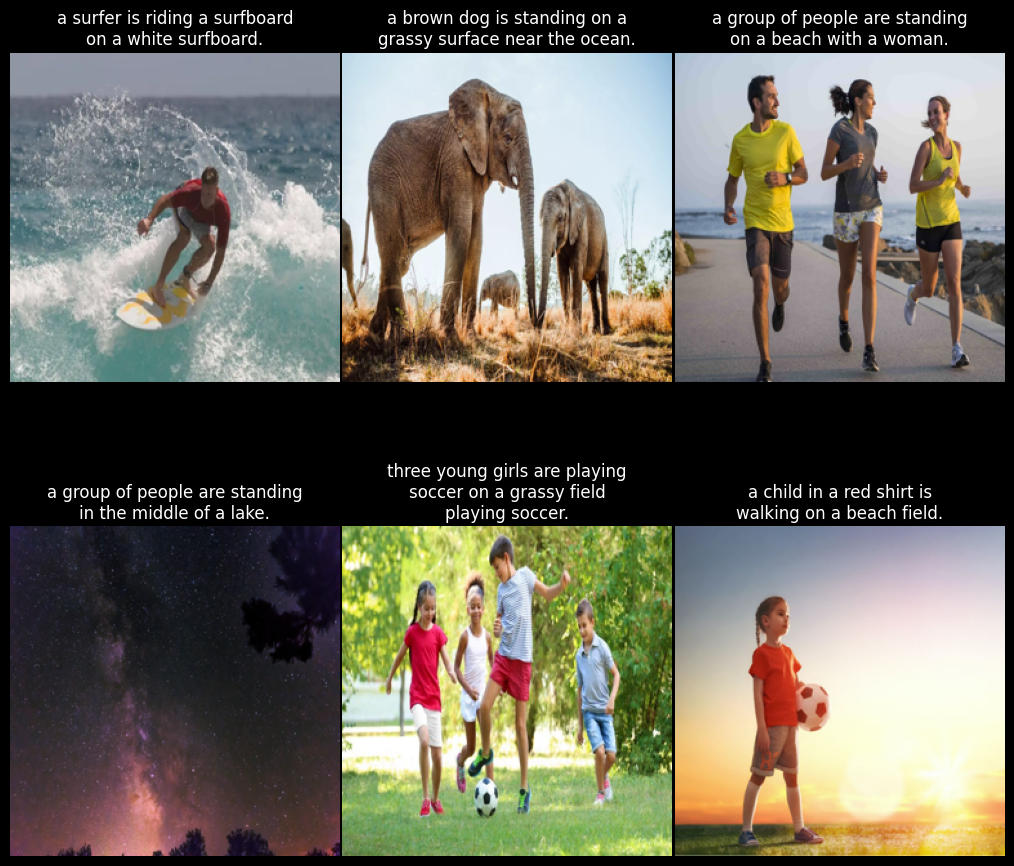

In [31]:
plt.style.use('dark_background')
plt.figure(figsize=(10, 10))
for i, url in enumerate(image_urls):
    image = download_url(url)
    caption, tokens = captioner.generate_caption(image, seq_length=15, top_p=.1, temperature=.1, 
                                                 return_tokens=True)

    # Plot image with their caption
    plt.subplot(2, 3, i + 1)
    plt.imshow(image)
    plt.title('\n'.join(wrap(caption, 30)), fontsize=12)
    plt.axis('off')
    
plt.tight_layout(pad=0.2, h_pad=.8)
plt.show()

In [ ]:
Model kami terlalu overfit pada dataset Flickr8k, sehingga tidak dapat melihat objek 
selain manusia dan hewan anjing. Model kami juga lebih sering men-generate kata pantai, kolam, dan salju
saat diberikan gambar yang tidak familiar. Model kami butuh dataset lebih besar.

In [ ]:
""" Refferences:
    [1] Daoust, M. (2018). "Image captioning with visual attention". 
        https://www.tensorflow.org/text/tutorials/image_captioning
    [2] Miculicich, L et al. (2023). "Summarization with Precise Length Control". 
        https://arxiv.org/abs/2305.05171
    [3] M. Hodosh, P. Young, and J. Hockenmaier. (2013). "Flickr 8k Dataset".
        https://www.kaggle.com/datasets/adityajn105/flickr8k
    [4] Holtzman, A. et al. (2019). "The Curious Case of Neural Text Degeneration".
        https://arxiv.org/abs/1904.09751
    [5] Vaswani, A. et al. (2017). "Attention Is All You Need".
        https://arxiv.org/abs/1706.03762
"""